In [76]:
import numpy as np
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
%config InlineBackend.figure_format = 'retina'

In [2]:
np.set_printoptions(suppress=True)

In [3]:
data = load_boston()
sclr = StandardScaler()
df = pd.DataFrame(sclr.fit_transform(data.data), columns=data.feature_names)
df['price'] = data.target
data = df.values

In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [5]:
def MSE(y: np.array, pred: np.array) -> float:
    """
    It finds the mean squared error for
    the converged intercept and weight
    vector using the dataset. Mostly the
    given dataset should be cross-validation
    dataset to reduce the overfitting. The
    following implementation was kept vectorized
    so that we can use amazing speed of numpy.
    """

    assert (y.shape[0] == pred.shape[0])
    N = pred.shape[0]
    y = y.reshape(N, 1)
    pred = pred.reshape(N, 1)
    residuals = y - pred
    squared_errors = np.power(residuals, 2)
    total_squared_errors = np.sum(squared_errors, axis=0)
    mse = (1.0 / N) * total_squared_errors
    return round(mse[0], 5)

In [6]:
def predict(X, W, b):
    N, d = X.shape
    W = W.reshape(d, 1)
    return (X @ W) + b

In [36]:
def SGD(training_frame,
        validation_frame=None,
        use_validation_error=False,
        random_state=42,
        loss='squared_loss',
        tol=1e-3,
        learning_rate='adaptive',
        eta0=0.01,
        early_stopping=True,
        no_iter_change=5,
        max_iters=1000,
        batch_size=100,
        verbose=False,) -> dict:
    """
    Non-regularized SGD for Linear Regression.
    SGD stands for Stochastic Gradient Descent: the gradient
    of the loss is estimated each sample at a time
    and the model is updated along the way with a
    decreasing strength schedule (aka learning rate).

    Parameters
    ----------

    training_frame: np.ndarray:
        The feature set for training from the dataset

    validation_frame: np.array:
        The feature set for cross validation from the dataset

    use_validation_error: bool, default: False:
        If validation error is to be used at all steps for errors

    loss: str, default: 'squared_loss'
        The loss function to be used

    tol: float or None, default: 1e-3
        Tolerance level of the stopping criteria

    random_state: int
        The random_state to be used for random seed

    learning_rate: str, default: 'adaptive'
        The type of learning rate.
        If 'adaptive': make eta0 = eta0 / 5 if new
                       error > old_error - tol
        If 'constant': Don't change eta0

    eta0: float, default: 0.01
        The basic value of gradient multiplier, controlled by learning_rate

    early_stopping: bool, default: True
        If early stopping needs to be used to reduce the overfitting

    no_iter_change: int, default: 5
        If early_stopping is Ture, the this variable controls the number
        of iterations fitting needs to be done even after no decrease in
        error

    max_iters: int, default: 1000
        Maximum number of times the iteration would run if early_stopping
        is False. At no point total iteration would go beyond max_iters.

    batch_size: int, default: 100
        Number of stochastic datapoints to reduce the computation

    verbose: bool, default: False
        If detailed progress needs to be should during the convergence
        of the algorithm.
    """

    # Define the initial W
    np.random.seed(random_state)
    multiplier = np.random.randint(low=5)
    np.random.seed(random_state)
    W = np.random.random(size=data.shape[1] - 1) * multiplier
    W = W.reshape(data.shape[1] - 1, 1)

    # Define the initial intercept
    b = 0

    pE = np.Inf  # Set the initial error to infinite

    
    # Check if we are using validation dataset also
    if validation_frame is not None:
        cv_X = validation_frame[:, 0:-1]
        cv_y = validation_frame[:, -1]

    for each_iter in range(1, max_iters):

        start = time()

        if verbose:
            print(f'======= Converging for iter {each_iter} =======')

        np.random.seed(random_state)
        
        # Creating stochastic samples from the bigger dataset of batch_size
        sample = training_frame[np.random.choice(training_frame.shape[0], 
                                                 batch_size, replace=False), :]

        X = sample[:, 0:-1]
        y = sample[:, -1]
        N, d = X.shape
        y = y.reshape(N, 1)

        # Store the previous weights and intercept
        pW = W.reshape(d, 1)
        pB = b

        # Find the derivatives of the weight and intercept
        dowW = y - predict(X, pW, pB)
        dW = X.T @ dowW
        dW = (-2.0 / N) * dW
        dB = (-2.0 / N) * np.sum(dowW)

        # Update the Weights and intercept
        W = pW - (eta0 * dW)
        b = pB - (eta0 * dB)

        #########################################
        
        # Predicting for the current W and intercept for training data
        pred = predict(X, W, b)
        
        # Predicting for the current W and intercept for validation data
        if validation_frame is not None:
            cv_pred = predict(cv_X, W, b)

        # Store the previous error
        error = pE
        
        # Check which loss is being used
        if loss == 'squared_loss':
            training_error = MSE(y, pred)  # Calculate the training loss
            if validation_frame is not  None:
                cv_error = MSE(cv_y, cv_pred)  # Calculate the validation loss if possible
        else:
            raise NotImplementedError(f"Currently given loss = {loss} is not implemented")
        
        # Define the base error depending on the ```use_validation_error``` variable
        if use_validation_error and validation_frame is not None:
            error = cv_error
        else:
            error = training_error

        if early_stopping:
            if error >= pE - tol and no_iter_change==0:
                if verbose:
                    print('!!!!!!!!!! Can not converge further !!!!!!!!!!')
                    print(f'Training error {training_error}')
                    if use_validation_error and cv_error:
                        print(f'Validation error {cv_error}')
                return {
                    'eta': eta0,
                    'W': W,
                    'b': b,
                    'iter': each_iter,
                    'train_MSE': training_error,
                    'CV_MSE': None if not cv_error else cv_error
                    }
            elif error >= pE - tol and no_iter_change != 0:
                no_iter_change -= 1
                if learning_rate == 'adaptive':
                    eta0 = eta0 / 5
                    if verbose:
                        print(f'Adaptive learning rate..New eta0 = {eta0}')
        elif learning_rate == 'adaptive' and not early_stopping and error >= pE - tol:
            if learning_rate == 'adaptive':
                eta0 = eta0 / 5
                if verbose:
                    print(f'Adaptive learning rate..New eta0 = {eta0}')

        pE = error
        end = time()

        if verbose:
            print(f'\n\tTraining error: {error} \n')
            print(f' ======= Convergence took {round(end - start, 7)} secs ======= \n\n')
    return {
        'eta': eta0,
        'W': W,
        'b': b,
        'iter': max_iters,
        'train_MSE': training_error,
        'CV_MSE': None if not cv_error else cv_error
    }

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data[:, 0:-1], data[:, -1], test_size=0.33, random_state=42)

tf = np.hstack((X_train, y_train.reshape(len(y_train), 1)))
vf = np.hstack((X_test, y_test.reshape(len(y_test), 1)))

# tf = data[0:350]
# vf = data[351:]



In [38]:
tf.shape

(339, 14)

In [39]:
vf.shape

(167, 14)

In [40]:
mysgd = SGD(training_frame=tf, validation_frame=vf,
          random_state=42, verbose=True, max_iters=10000,
          learning_rate='adaptive', eta0=1.0, use_validation_error=True, early_stopping=True)

======= Converging for iter 1 =======

	Training error: 9930.73133 

 ======= Convergence took 0.0007911 secs ======= 


======= Converging for iter 2 =======
Adaptive learning rate..New eta0 = 0.2

	Training error: 859340.74025 

 ======= Convergence took 0.0005791 secs ======= 


======= Converging for iter 3 =======
Adaptive learning rate..New eta0 = 0.04

	Training error: 1169092.73649 

 ======= Convergence took 0.0013239 secs ======= 


======= Converging for iter 4 =======

	Training error: 379506.02676 

 ======= Convergence took 0.0014119 secs ======= 


======= Converging for iter 5 =======

	Training error: 123603.42522 

 ======= Convergence took 0.0008869 secs ======= 


======= Converging for iter 6 =======

	Training error: 40514.18507 

 ======= Convergence took 0.0005779 secs ======= 


======= Converging for iter 7 =======

	Training error: 13448.44951 

 ======= Convergence took 0.0006893 secs ======= 


======= Converging for iter 8 =======

	Training error: 4580.21

In [16]:
clf = LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
cv_MSE = mean_squared_error(y_test, pred)

In [42]:
from prettytable import PrettyTable

x = PrettyTable(field_names=['Impementation', 'CV_MSE', 'intercept'])

x.add_row(['my implmentation', mysgd['CV_MSE'], mysgd['b']])
x.add_row(['sklearn', round(cv_MSE, 5), clf.intercept_])
print(x)

+------------------+----------+--------------------+
|  Impementation   |  CV_MSE  |     intercept      |
+------------------+----------+--------------------+
| my implmentation | 28.17289 | 21.634976189403964 |
|     sklearn      | 20.74714 | 22.464701925047212 |
+------------------+----------+--------------------+


In [52]:
clf.coef_

array([-1.09981901,  0.88061392,  0.40169312,  0.82214489, -1.87794024,
        2.73295106, -0.35961161, -2.99402827,  2.03994748, -1.38107772,
       -2.01130185,  1.08671576, -3.91292854])

In [53]:
W = mysgd['W'].reshape(13,)
W

array([-0.56851564, -0.69505475,  0.42050422,  0.02083665, -0.88719957,
        4.25883701, -0.75013024, -1.40109214,  0.5141078 , -0.88356384,
       -1.30334031,  0.52600083, -4.64801388])

In [58]:
Weights = pd.DataFrame({'sklearn_W': clf.coef_, 'mysgd_W': W})

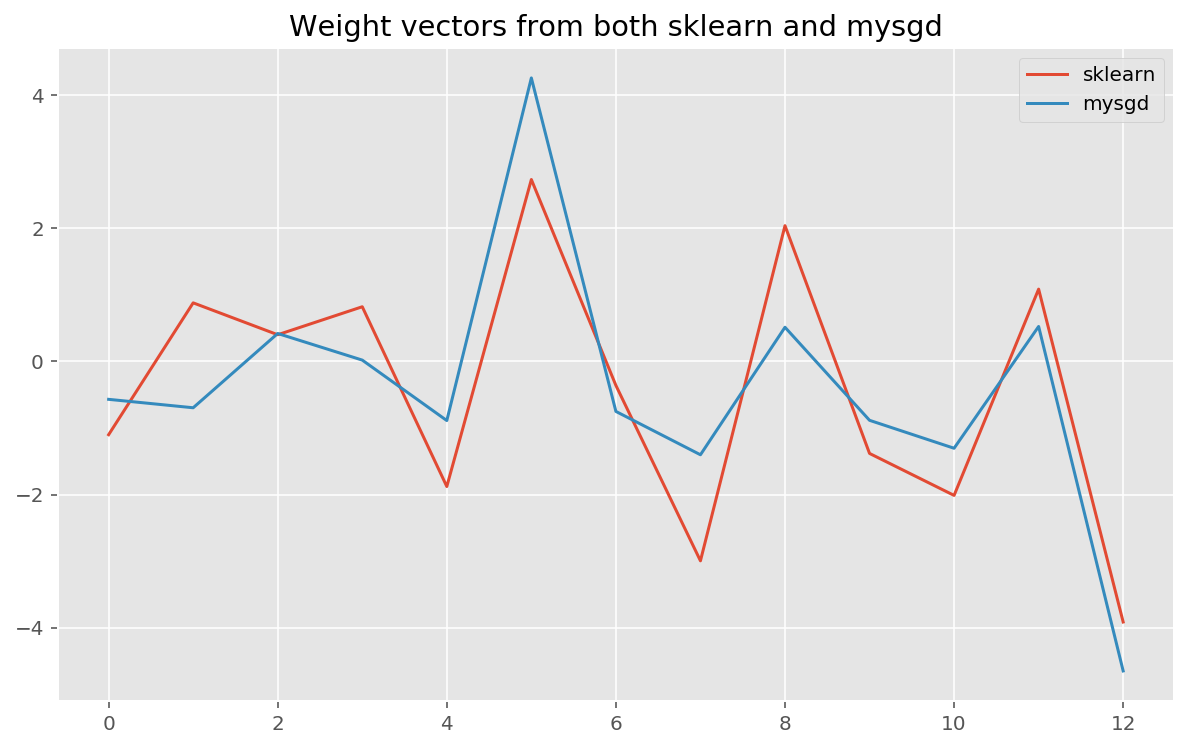

In [81]:
fig = plt.figure()
plt.plot(Weights.sklearn_W)
plt.plot(Weights.mysgd_W)
plt.title('Weight vectors from both sklearn and mysgd')
plt.legend(['sklearn', 'mysgd'])
plt.show()